In [11]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import math
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, accuracy_score

def safe_adamic_adar_index(G, ebunch=None):
    """Compute Adamic-Adar index safely to handle ZeroDivisionError."""
    def predictor(u, v):
        try:
            return sum(1 / max(1, math.log(G.degree(w))) for w in nx.common_neighbors(G, u, v))
        except ZeroDivisionError:
            return 0

    if ebunch is None:
        ebunch = nx.non_edges(G)

    return ((u, v, predictor(u, v)) for u, v in ebunch)

class LinkPrediction:
    def __init__(self, dataset):
        self.G = nx.from_pandas_edgelist(dataset, source='Source', target='Target', create_using=nx.Graph())
        self.roc_data = {}

    def analyze_network(self):
        """Analyze the network structure."""
        print("\n=== Network Analysis ===")
        print(f"Number of nodes: {self.G.number_of_nodes()}")
        print(f"Number of edges: {self.G.number_of_edges()}")
        print(f"Average clustering coefficient: {nx.average_clustering(self.G):.3f}")

        plt.figure(figsize=(15, 5))
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue', node_size=500)
        plt.title("Network Structure")
        plt.show()

    def prepare_data(self):
        """Prepare training and testing data."""
        edges = list(self.G.edges())
        np.random.seed(42)
        np.random.shuffle(edges)

        n_test = int(len(edges) * 0.2)
        self.test_edges = edges[:n_test]
        self.train_edges = edges[n_test:]

        self.train_G = self.G.copy()
        self.train_G.remove_edges_from(self.test_edges)

        non_edges = list(nx.non_edges(self.train_G))
        np.random.shuffle(non_edges)
        self.test_non_edges = non_edges[:n_test]
        print(f"Train edges: {len(self.train_edges)}")
        print(f"Test positive edges: {len(self.test_edges)}")
        print(f"Test negative edges: {len(self.test_non_edges)}")

    def extract_features(self, G, u, v):
        """Extract features for node pairs."""
        cn = len(list(nx.common_neighbors(G, u, v)))
        jc = list(nx.jaccard_coefficient(G, [(u, v)]))[0][2]
        aa = list(safe_adamic_adar_index(G, [(u, v)]))[0][2]  # Use safe version
        return [cn, jc, aa]

    def prepare_ml_data(self, G, positive_edges, negative_edges):
        """Prepare data for machine learning."""
        X = [self.extract_features(G, u, v) for u, v in positive_edges + negative_edges]
        y = [1] * len(positive_edges) + [0] * len(negative_edges)
        return np.array(X), np.array(y)

    def evaluate_baselines(self):
        """Evaluate traditional methods."""
        methods = {
            'Common Neighbors': lambda u, v: len(list(nx.common_neighbors(self.train_G, u, v))),
            'Jaccard Coefficient': lambda u, v: list(nx.jaccard_coefficient(self.train_G, [(u, v)]))[0][2],
            'Adamic-Adar': lambda u, v: list(safe_adamic_adar_index(self.train_G, [(u, v)]))[0][2]
        }

        results = []

        for name, score_func in methods.items():
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            y_pred = [1 if score > 0 else 0 for score in y_scores]

            auc = roc_auc_score(y_true, y_scores)
            acc = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)

            results.append({
                "Method": name,
                "AUC": auc,
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1-score": f1
            })

        self.results_df = pd.DataFrame(results)

        plt.figure(figsize=(10, 6))
        for name, score_func in methods.items():
            pos_scores = [score_func(u, v) for u, v in self.test_edges]
            neg_scores = [score_func(u, v) for u, v in self.test_non_edges]

            y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
            y_scores = pos_scores + neg_scores
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            self.roc_data[name] = (fpr, tpr, roc_auc_score(y_true, y_scores))

    def evaluate_ml(self):
        """Train and evaluate ML model."""
        X, y = self.prepare_ml_data(self.train_G, self.test_edges, self.test_non_edges)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        auc = roc_auc_score(y_test, y_pred_proba)
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        rf_results = pd.DataFrame([{
            "Method": "Random Forest",
            "AUC": auc,
            "Accuracy": acc,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }])

        self.results_df = pd.concat([self.results_df, rf_results], ignore_index=True)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        self.roc_data["Random Forest"] = (fpr, tpr, auc)
    def plot_combined_roc_curves(self):
        """Plot all ROC curves together."""
        print("\nComparison Results:")
        print(self.results_df)
        plt.figure(figsize=(10, 8))
        for name, (fpr, tpr, auc) in self.roc_data.items():
            plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves Comparison')
        plt.legend()
        plt.show()

    def run_experiment(self):
        """Run the full experiment."""
        self.analyze_network()
        self.prepare_data()
        self.evaluate_baselines()
        self.evaluate_ml()
        self.plot_combined_roc_curves()



=== Network Analysis ===
Number of nodes: 398
Number of edges: 4011
Average clustering coefficient: 0.610


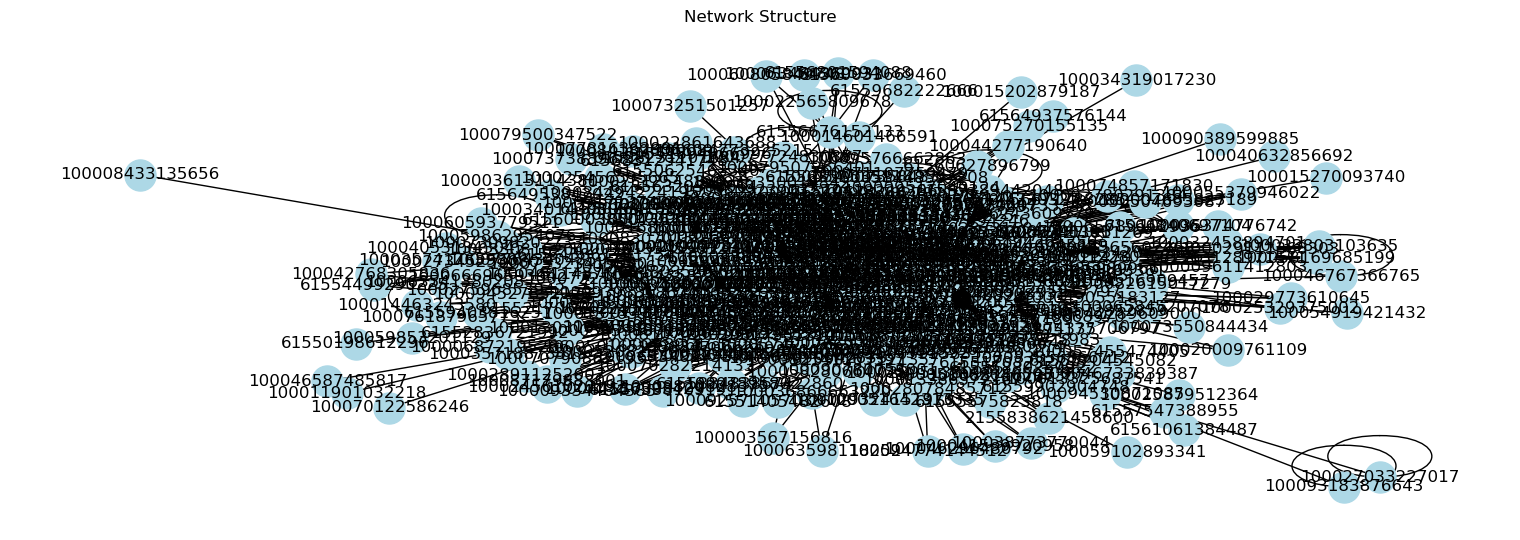

Train edges: 3209
Test positive edges: 802
Test negative edges: 802

Comparison Results:
                Method       AUC  Accuracy  Precision    Recall  F1-score
0     Common Neighbors  0.925112  0.781796   0.701786  0.980050  0.817898
1  Jaccard Coefficient  0.894753  0.781796   0.701786  0.980050  0.817898
2          Adamic-Adar  0.932743  0.781796   0.701786  0.980050  0.817898
3        Random Forest  0.910462  0.844398   0.852000  0.848606  0.850299


<Figure size 1000x600 with 0 Axes>

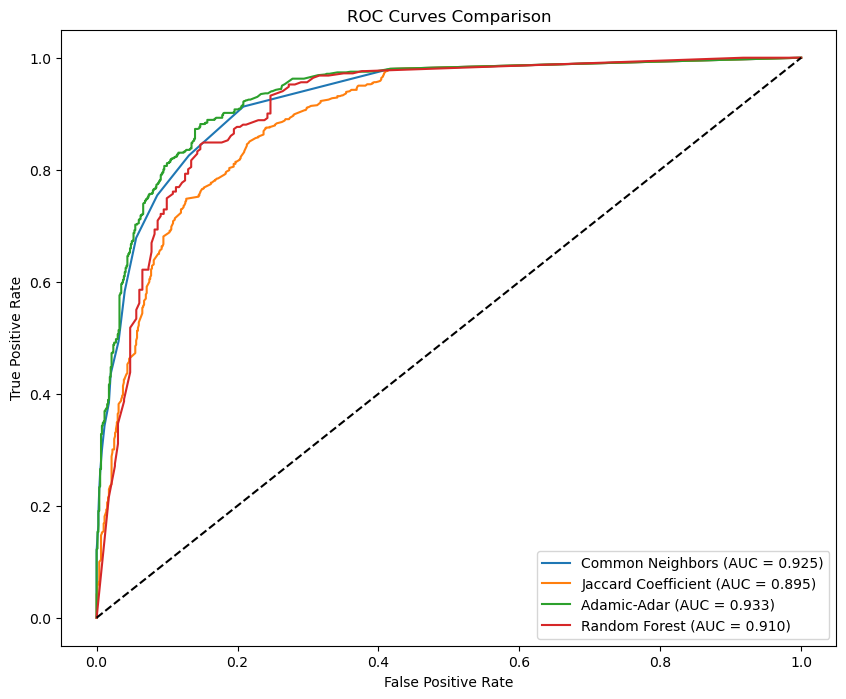

In [12]:
if __name__ == "__main__":
    data_path = 'graph_edges.xlsx'
    df = pd.read_excel(data_path)
    lp = LinkPrediction(dataset=df)
    lp.run_experiment()
else:
        print("Lựa chọn không hợp lệ!")
